In [35]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2025-12-13 16:15:41--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-12-13 16:15:41--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.2’

shape_predictor_68_ 100%[===================>]  61.07M  39.2MB/s    in 1.6s    

2025-12-13 16:15:42 (39.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile

PROJECT_ROOT = Path(".")
IMG_DIR = PROJECT_ROOT / "img_align_celeba"
IMG_ZIP = PROJECT_ROOT / "img_align_celeba.zip"

# Extract images if not already extracted
if not IMG_DIR.exists():
    print("Extracting images from zip...")
    with zipfile.ZipFile(IMG_ZIP, 'r') as zip_ref:
        zip_ref.extractall(PROJECT_ROOT)

ATTR_PATH = PROJECT_ROOT / "celeba_front_facing.csv"
PREDICTOR_PATH = PROJECT_ROOT / "shape_predictor_68_face_landmarks.dat"

# load in the CSV
attr_df = pd.read_csv(ATTR_PATH)
print("CSV loaded:", attr_df.shape)


# get subset of data
available_imgs = set(os.listdir(IMG_DIR))
attr_df = attr_df[attr_df["image_id"].isin(available_imgs)].copy()
print("Filtered CSV shape:", attr_df.shape)

# initialize dlib (landmark detectors)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)
print("dlib models loaded")

# landmark helpers
def get_landmarks(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    if len(faces) == 0:
        return None

    shape = predictor(gray, faces[0])
    coords = np.zeros((68, 2), dtype="int")
    for i in range(68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def draw_landmarks(img, landmarks):
    vis = img.copy()
    for (x, y) in landmarks:
        cv2.circle(vis, (x, y), 2, (0, 255, 0), -1)
    return vis

def crop_region(img, landmarks, indices, padding=10):
    pts = landmarks[indices]
    x1, y1 = pts.min(axis=0)
    x2, y2 = pts.max(axis=0)

    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(img.shape[1], x2 + padding)
    y2 = min(img.shape[0], y2 + padding)

    return img[y1:y2, x1:x2]


# landmark index groups (68-point for dlib)
LEFT_EYE = list(range(42, 48))
RIGHT_EYE = list(range(36, 42))
NOSE = list(range(27, 36))
LIPS = list(range(48, 68))



ModuleNotFoundError: No module named 'dlib'

In [40]:
# cropping setup with region map and ranges for the features

LEFT_EYE = list(range(42, 48))
RIGHT_EYE = list(range(36, 42))
NOSE = list(range(27, 36))
LIPS = list(range(48, 68))
JAW = list(range(0, 17))
EYEBROWS = list(range(17, 27))

ATTRIBUTE_REGION_MAP = {
    "Big_Lips": ("lips", LIPS),
    "Big_Nose": ("nose", NOSE),
    "Pointy_Nose": ("nose", NOSE),
    "High_Cheekbones": ("cheeks", JAW),
    "Oval_Face": ("face", JAW),
    "Arched_Eyebrows": ("eyes", LEFT_EYE + RIGHT_EYE + EYEBROWS),
    "Narrow_Eyes": ("eyes", LEFT_EYE + RIGHT_EYE),
    "Eyeglasses": ("face", JAW + LEFT_EYE + RIGHT_EYE),
    "Rosy_Cheeks": ("cheeks", JAW),
    "Pale_Skin": ("face", JAW),
}

CROP_ROOT = f"{PROJECT_ROOT}/crops"

for attr, (region, _) in ATTRIBUTE_REGION_MAP.items():
    out_dir = f"{CROP_ROOT}/{region}/{attr}"
    os.makedirs(out_dir, exist_ok=True)


In [41]:
# actual cropping loop for each attribute
for attr, (region, indices) in ATTRIBUTE_REGION_MAP.items():
  subset = attr_df[attr_df[attr] == 1]
  print(f"{attr}: {len(subset)} images")

  for img_name in subset["image_id"]:
      img_path = f"{IMG_DIR}/{img_name}"
      img = cv2.imread(img_path)

      if img is None:
          continue

      landmarks = get_landmarks(img)
      if landmarks is None:
          continue

      crop = crop_region(img, landmarks, indices, padding=15)

      # saves the cropped images in folders
      out_path = f"{CROP_ROOT}/{region}/{attr}/{img_name}"
      cv2.imwrite(out_path, crop)

print("All crops saved")

Big_Lips: 8 images
Big_Nose: 6 images
Pointy_Nose: 4 images
High_Cheekbones: 11 images
Oval_Face: 11 images
Arched_Eyebrows: 6 images
Narrow_Eyes: 0 images
Eyeglasses: 2 images
Rosy_Cheeks: 0 images
Pale_Skin: 1 images
All crops saved


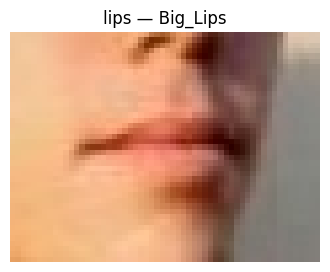

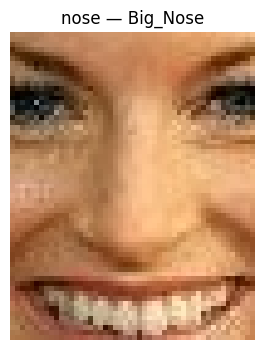

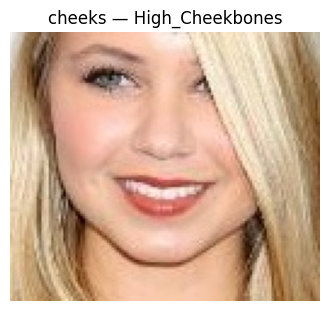

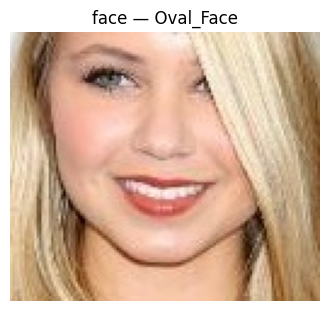

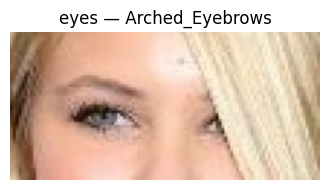

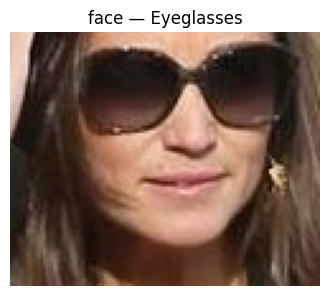

In [44]:
# helpers to show/print the cropped images
def show(img, title="Image"):
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


def show_random(region, attr):
    folder = f"{CROP_ROOT}/{region}/{attr}"
    sample = os.listdir(folder)[0]
    img = cv2.imread(f"{folder}/{sample}")
    show(img, f"{region} — {attr}")

show_random("lips", "Big_Lips")
show_random("nose", "Big_Nose")
show_random("cheeks", "High_Cheekbones")
show_random("face", "Oval_Face")
show_random("eyes", "Arched_Eyebrows")
show_random("face", "Eyeglasses")